In [30]:
# Standard libraries
import os
import time

# Data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import models, transforms
from torchvision.models.feature_extraction import create_feature_extractor

# Other ML/NLP utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
from einops import rearrange

# Segmentation models and vision transformers
import segmentation_models_pytorch as smp
import timm


## Dataset Preparation

In [2]:
image_dir = "/content/drive/MyDrive/Colab Notebooks/Lung_Segmentation_Dataset/images"
mask_dir = "/content/drive/MyDrive/Colab Notebooks/Lung_Segmentation_Dataset/masks"

def load_dataset(image_dir, mask_dir, img_size=(256, 256)):
    images, masks = [], []

    # Extract available mask filenames without "-mask"
    mask_files = {filename.split('-mask')[0]: filename for filename in os.listdir(mask_dir)}

    matched_count = 0
    for filename in os.listdir(image_dir):
        base_name = filename.split('.')[0]  # Extract base name

        if base_name in mask_files:  # Only keep images that have masks
            img_path = os.path.join(image_dir, filename)
            mask_path = os.path.join(mask_dir, mask_files[base_name])

            img = load_img(img_path, target_size=img_size, color_mode='grayscale')
            mask = load_img(mask_path, target_size=img_size, color_mode='grayscale')

            images.append(img_to_array(img) / 255.0)
            masks.append(img_to_array(mask) / 255.0)
            matched_count += 1
        else:
            print(f"Skipping {filename}: No corresponding mask found.")

    print(f"Total images with masks loaded: {matched_count}")
    return np.array(images).reshape(-1, 256, 256, 1), np.array(masks).reshape(-1, 256, 256, 1)

# Load images and masks
X, Y = load_dataset(image_dir, mask_dir)

Skipping 110.png: No corresponding mask found.
Skipping 118.png: No corresponding mask found.
Skipping 10.png: No corresponding mask found.
Skipping 175.png: No corresponding mask found.
Skipping 150.png: No corresponding mask found.
Skipping 168.png: No corresponding mask found.
Skipping 158.png: No corresponding mask found.
Skipping 178.png: No corresponding mask found.
Skipping 179.png: No corresponding mask found.
Skipping 208.png: No corresponding mask found.
Skipping 219.png: No corresponding mask found.
Skipping 223.png: No corresponding mask found.
Skipping 210.png: No corresponding mask found.
Skipping 229.png: No corresponding mask found.
Skipping 234.png: No corresponding mask found.
Skipping 276.png: No corresponding mask found.
Skipping 264.png: No corresponding mask found.
Skipping 257.png: No corresponding mask found.
Skipping 273.png: No corresponding mask found.
Skipping 256.png: No corresponding mask found.
Skipping 296.png: No corresponding mask found.
Skipping 281.p

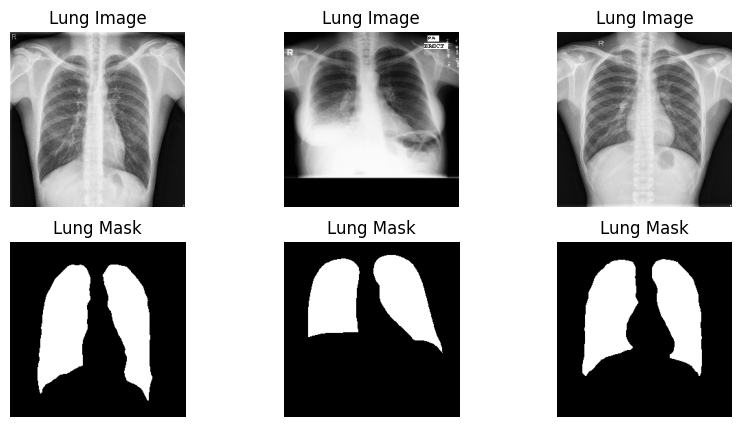

In [3]:
# Display sample images
plt.figure(figsize=(10,5))
for i in range(3):
    plt.subplot(2,3,i+1)
    plt.imshow(X[i].squeeze(), cmap='gray')
    plt.title("Lung Image")
    plt.axis('off')

    plt.subplot(2,3,i+4)
    plt.imshow(Y[i].squeeze(), cmap='gray')
    plt.title("Lung Mask")
    plt.axis('off')
plt.show()

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## Paper Code

In [ ]:
class EfficientNetEncoder(nn.Module):
    def __init__(self):
        super(EfficientNetEncoder, self).__init__()
        efficientnet = models.efficientnet_b0(pretrained=True)
        self.stem = nn.Sequential(efficientnet.features[0])   # 32 channels
        self.block1 = nn.Sequential(efficientnet.features[1]) # 16
        self.block2 = nn.Sequential(efficientnet.features[2]) # 24
        self.block3 = nn.Sequential(efficientnet.features[3]) # 40
        self.block4 = nn.Sequential(efficientnet.features[4]) # 80
        self.block5 = nn.Sequential(efficientnet.features[5:]) # up to 1280

    def forward(self, x):
      skips = []
      x = self.stem(x)
      skips.append(x)
      x = self.block1(x)
      skips.append(x)
      x = self.block2(x)
      skips.append(x)
      x = self.block3(x)
      skips.append(x)
      x = self.block4(x)
      skips.append(x)
      x = self.block5(x)
      return x, skips



class SpatialEnhancement(nn.Module):
    def __init__(self, in_channels):
        super(SpatialEnhancement, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.attn = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // 8, 1),
            nn.ReLU(),
            nn.Conv2d(in_channels // 8, in_channels, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        feat = self.conv(x)
        attn = self.attn(feat)
        return feat * attn


# --- Transformer Attention Module at Bottleneck ---
class TransformerBottleneck(nn.Module):
    def __init__(self, dim, heads=4):
        super(TransformerBottleneck, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=heads, batch_first=True)
        self.ffn = nn.Sequential(
            nn.Linear(dim, dim*4),
            nn.ReLU(),
            nn.Linear(dim*4, dim)
        )
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)

    def forward(self, x):
        B, C, H, W = x.shape
        x = rearrange(x, 'b c h w -> b (h w) c')
        x2, _ = self.attn(x, x, x)
        x = self.norm1(x + x2)
        x2 = self.ffn(x)
        x = self.norm2(x + x2)
        x = rearrange(x, 'b (h w) c -> b c h w', h=H, w=W)
        return x


# --- Multi-Scale Feature Fusion Block ---
class MultiScaleFusion(nn.Module):
    def __init__(self, in_channels):
        super(MultiScaleFusion, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.conv3 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels, in_channels, kernel_size=5, padding=2)
        self.fuse = nn.Conv2d(in_channels * 3, in_channels, kernel_size=1)

    def forward(self, x):
        f1 = self.conv1(x)
        f3 = self.conv3(x)
        f5 = self.conv5(x)
        return self.fuse(torch.cat([f1, f3, f5], dim=1))


# --- Decoder Block ---
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels):
        super(DecoderBlock, self).__init__()
        self.align_channels = nn.Conv2d(in_channels, skip_channels, kernel_size=1)
        self.fusion = MultiScaleFusion(skip_channels)

    def forward(self, x, skip):
        x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=True)
        x = self.align_channels(x)
        x = x + skip
        return self.fusion(x)

# --- Full Segmentation Network ---
class SegmentationNet(nn.Module):
    def __init__(self, num_classes):
        super(SegmentationNet, self).__init__()
        self.encoder = EfficientNetEncoder()
        self.spatial_modules = nn.ModuleList([
        SpatialEnhancement(32),  # stem
        SpatialEnhancement(16),  # block1
        SpatialEnhancement(24),  # block2
        SpatialEnhancement(40),  # block3
        SpatialEnhancement(80),  # block4
    ])

        self.bottleneck = TransformerBottleneck(dim=1280)
        self.decoder5 = DecoderBlock(1280, 80)   # skip[4]
        self.decoder4 = DecoderBlock(80, 40)     # skip[3]
        self.decoder3 = DecoderBlock(40, 24)     # skip[2]
        self.decoder2 = DecoderBlock(24, 16)     # skip[1]
        self.decoder1 = DecoderBlock(16, 32)     # skip[0]

        self.final = nn.Conv2d(32, num_classes, kernel_size=1)

    def forward(self, x):
        x, skips = self.encoder(x)
        x = self.bottleneck(x)
        for i in range(len(skips)):
            skips[i] = self.spatial_modules[i](skips[i])
        x = self.decoder5(x, skips[4])
        x = self.decoder4(x, skips[3])
        x = self.decoder3(x, skips[2])
        x = self.decoder2(x, skips[1])
        x = self.decoder1(x, skips[0])
        return F.interpolate(self.final(x), size=(256, 256), mode='bilinear', align_corners=True)

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert your numpy arrays to PyTorch tensors
# X_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)  # (N, 1, 256, 256)
X_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2).repeat(1, 3, 1, 1)
y_tensor = torch.tensor(y_train, dtype=torch.long).squeeze(3)  # (N, 256, 256)

# X_val_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)
X_val_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2).repeat(1, 3, 1, 1)
y_val_tensor = torch.tensor(y_test, dtype=torch.long).squeeze(3)

# Create DataLoaders
train_dataset = TensorDataset(X_tensor, y_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [ ]:
# Initialize model
model = SegmentationNet(num_classes=2).to(device)

# Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# --- Training Loop ---
train_losses = []
train_accuracies = []

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct_pixels = 0
    total_pixels = 0

    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        outputs = model(imgs)

        # Resize outputs if needed
        outputs = F.interpolate(outputs, size=masks.shape[1:], mode='bilinear', align_corners=True)

        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        correct_pixels += (preds == masks).sum().item()
        total_pixels += masks.numel()

    avg_loss = train_loss / len(train_loader)
    acc = 100 * correct_pixels / total_pixels
    train_losses.append(avg_loss)
    train_accuracies.append(acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}, Accuracy: {acc:.2f}%")

# --- Save the model ---
torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/efficientNet_model.keras")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10] - Loss: 0.2605, Accuracy: 87.78%
Epoch [2/10] - Loss: 0.0804, Accuracy: 97.03%
Epoch [3/10] - Loss: 0.0657, Accuracy: 97.55%
Epoch [4/10] - Loss: 0.0572, Accuracy: 97.78%
Epoch [5/10] - Loss: 0.0532, Accuracy: 97.94%
Epoch [6/10] - Loss: 0.0502, Accuracy: 98.05%
Epoch [7/10] - Loss: 0.0459, Accuracy: 98.18%
Epoch [8/10] - Loss: 0.0427, Accuracy: 98.30%
Epoch [9/10] - Loss: 0.0415, Accuracy: 98.34%
Epoch [10/10] - Loss: 0.0401, Accuracy: 98.39%


In [ ]:
model.eval()
val_loss = 0
correct_pixels = 0
total_pixels = 0

all_preds = []
all_targets = []

with torch.no_grad():
    for imgs, masks in val_loader:
        imgs, masks = imgs.to(device), masks.to(device)

        outputs = model(imgs)
        outputs = F.interpolate(outputs, size=masks.shape[1:], mode='bilinear', align_corners=True)
        loss = criterion(outputs, masks)
        val_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        correct_pixels += (preds == masks).sum().item()
        total_pixels += masks.numel()

        all_preds.append(preds.cpu().flatten())
        all_targets.append(masks.cpu().flatten())

avg_val_loss = val_loss / len(val_loader)
val_accuracy = 100 * correct_pixels / total_pixels

print(f"\n Test Accuracy: {val_accuracy:.2f}%")



Test accurcy : 96.69


## Our Improvement  
**EfficientNetB0**

In [23]:
class EfficientNetEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.efficientnet_b0(pretrained=True)
        self.blocks = nn.ModuleList([
            base.features[0],  # 32
            base.features[1],  # 16
            base.features[2],  # 24
            base.features[3],  # 40
            base.features[4],  # 80
            nn.Sequential(*base.features[5:])  # 1280
        ])

    def forward(self, x):
        skips = []
        for i, block in enumerate(self.blocks[:-1]):
            x = block(x)
            skips.append(x)
        x = self.blocks[-1](x)
        return x, skips

class SpatialEnhancement(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.conv = nn.Conv2d(ch, ch, 3, padding=1)
        self.attn = nn.Sequential(
            nn.Conv2d(ch, ch // 8, 1),
            nn.ReLU(),
            nn.Conv2d(ch // 8, ch, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv(x)
        return x * self.attn(x)

class TransformerBottleneck(nn.Module):
    def __init__(self, dim, heads=4):
        super().__init__()
        self.attn = nn.MultiheadAttention(dim, heads, batch_first=True)
        self.ffn = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.ReLU(),
            nn.Linear(dim * 4, dim)
        )
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)

    def forward(self, x):
        B, C, H, W = x.shape
        x = rearrange(x, 'b c h w -> b (h w) c')
        attn_out, _ = self.attn(x, x, x)
        x = self.norm1(x + attn_out)
        x = self.norm2(x + self.ffn(x))
        return rearrange(x, 'b (h w) c -> b c h w', h=H, w=W)

class MultiScaleFusion(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.branches = nn.ModuleList([
            nn.Conv2d(ch, ch, 1),
            nn.Conv2d(ch, ch, 3, padding=1),
            nn.Conv2d(ch, ch, 5, padding=2)
        ])
        self.fuse = nn.Conv2d(ch * 3, ch, 1)

    def forward(self, x):
        feats = [conv(x) for conv in self.branches]
        return self.fuse(torch.cat(feats, dim=1))

class DecoderBlock(nn.Module):
    def __init__(self, in_ch, skip_ch):
        super().__init__()
        self.align = nn.Conv2d(in_ch, skip_ch, 1)
        self.fusion = MultiScaleFusion(skip_ch)

    def forward(self, x, skip):
        x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=True)
        x = self.align(x)
        return self.fusion(x + skip)

class SegmentationNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.encoder = EfficientNetEncoder()
        skip_channels = [32, 16, 24, 40, 80]  # from encoder
        self.spatial = nn.ModuleList([SpatialEnhancement(c) for c in skip_channels])
        self.bottleneck = TransformerBottleneck(1280)
        self.decoders = nn.ModuleList([
            DecoderBlock(1280, 80),
            DecoderBlock(80, 40),
            DecoderBlock(40, 24),
            DecoderBlock(24, 16),
            DecoderBlock(16, 32),
        ])
        self.final = nn.Conv2d(32, num_classes, 1)

    def forward(self, x):
        x, skips = self.encoder(x)
        x = self.bottleneck(x)
        skips = [mod(s) for mod, s in zip(self.spatial, skips)]
        for dec, skip in zip(self.decoders, reversed(skips)):
            x = dec(x, skip)
        x = self.final(x)
        return F.interpolate(x, size=(256, 256), mode='bilinear', align_corners=True)


In [24]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert your numpy arrays to PyTorch tensors
X_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2).repeat(1, 3, 1, 1)
y_tensor = torch.tensor(y_train, dtype=torch.long).squeeze(3)  # (N, 256, 256)

X_val_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2).repeat(1, 3, 1, 1)
y_val_tensor = torch.tensor(y_test, dtype=torch.long).squeeze(3)

# Create DataLoaders
train_dataset = TensorDataset(X_tensor, y_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [25]:
# Initialize model
model = SegmentationNet(num_classes=2).to(device)

# Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# --- Training Loop ---
train_losses = []
train_accuracies = []

num_epochs = 10
total_start_time = time.time()  # Start total timer

for epoch in range(num_epochs):
    start_time = time.time()  # Start epoch timer

    model.train()
    train_loss = 0
    correct_pixels = 0
    total_pixels = 0

    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        outputs = model(imgs)

        # Resize outputs if needed
        outputs = F.interpolate(outputs, size=masks.shape[1:], mode='bilinear', align_corners=True)

        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        correct_pixels += (preds == masks).sum().item()
        total_pixels += masks.numel()

    avg_loss = train_loss / len(train_loader)
    acc = 100 * correct_pixels / total_pixels
    train_losses.append(avg_loss)
    train_accuracies.append(acc)

    end_time = time.time()
    epoch_time = end_time - start_time

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}, Accuracy: {acc:.2f}% - Time: {epoch_time:.2f}s")

total_end_time = time.time()
total_time = total_end_time - total_start_time

print(f"\nTotal Training Time: {total_time:.2f} seconds ({total_time/60:.2f} minutes)")

# --- Save the model ---
torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/EfficientNetB0.keras")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 123MB/s]


Epoch [1/10] - Loss: 0.2428, Accuracy: 89.01% - Time: 13.09s
Epoch [2/10] - Loss: 0.0769, Accuracy: 97.13% - Time: 10.46s
Epoch [3/10] - Loss: 0.0617, Accuracy: 97.62% - Time: 9.87s
Epoch [4/10] - Loss: 0.0556, Accuracy: 97.82% - Time: 9.83s
Epoch [5/10] - Loss: 0.0508, Accuracy: 98.00% - Time: 9.80s
Epoch [6/10] - Loss: 0.0466, Accuracy: 98.15% - Time: 9.81s
Epoch [7/10] - Loss: 0.0432, Accuracy: 98.28% - Time: 9.74s
Epoch [8/10] - Loss: 0.0424, Accuracy: 98.30% - Time: 9.83s
Epoch [9/10] - Loss: 0.0406, Accuracy: 98.37% - Time: 9.89s
Epoch [10/10] - Loss: 0.0389, Accuracy: 98.43% - Time: 9.90s

Total Training Time: 102.22 seconds (1.70 minutes)


In [26]:
model.eval()
val_loss = 0
correct_pixels = 0
total_pixels = 0

all_preds = []
all_targets = []

with torch.no_grad():
    for imgs, masks in val_loader:
        imgs, masks = imgs.to(device), masks.to(device)

        outputs = model(imgs)
        outputs = F.interpolate(outputs, size=masks.shape[1:], mode='bilinear', align_corners=True)
        loss = criterion(outputs, masks)
        val_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        correct_pixels += (preds == masks).sum().item()
        total_pixels += masks.numel()

        all_preds.append(preds.cpu().flatten())
        all_targets.append(masks.cpu().flatten())

avg_val_loss = val_loss / len(val_loader)
val_accuracy = 100 * correct_pixels / total_pixels

print(f"\n📊 Test Accuracy: {val_accuracy:.2f}%")
print(f"📉 Test Loss: {avg_val_loss:.4f}")



📊 Test Accuracy: 97.86%
📉 Test Loss: 0.0607


In [27]:
all_preds_flat = torch.cat(all_preds).numpy()
all_targets_flat = torch.cat(all_targets).numpy()

print("\n📝 Classification Report:")
print(classification_report(all_targets_flat, all_preds_flat, target_names=["Background", "Class 1"]))


📝 Classification Report:
              precision    recall  f1-score   support

  Background       0.98      0.99      0.99   6903734
     Class 1       0.96      0.95      0.96   2336842

    accuracy                           0.98   9240576
   macro avg       0.97      0.97      0.97   9240576
weighted avg       0.98      0.98      0.98   9240576



**MobileNetV2**

In [17]:
class MobileNetV2Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.mobilenet_v2(pretrained=True).features

        # Define the blocks based on MobileNetV2 architecture stages
        self.blocks = nn.ModuleList([
            base[0],                     # Conv 3x3 (32)
            nn.Sequential(*base[1:3]),   # InvertedResidual (16)
            nn.Sequential(*base[3:6]),   # InvertedResidual (24)
            nn.Sequential(*base[6:10]),  # InvertedResidual (32)
            nn.Sequential(*base[10:14]), # InvertedResidual (64)
            nn.Sequential(*base[14:]),   # InvertedResidual (96, 160, 320) + Conv1x1(1280)
        ])

    def forward(self, x):
        skips = []
        for block in self.blocks[:-1]:
            x = block(x)
            skips.append(x)
        x = self.blocks[-1](x)
        return x, skips

class SpatialEnhancement(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.conv = nn.Conv2d(ch, ch, 3, padding=1)
        self.attn = nn.Sequential(
            nn.Conv2d(ch, ch // 8, 1),
            nn.ReLU(),
            nn.Conv2d(ch // 8, ch, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv(x)
        return x * self.attn(x)

class TransformerBottleneck(nn.Module):
    def __init__(self, dim, heads=4):
        super().__init__()
        self.attn = nn.MultiheadAttention(dim, heads, batch_first=True)
        self.ffn = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.ReLU(),
            nn.Linear(dim * 4, dim)
        )
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)

    def forward(self, x):
        B, C, H, W = x.shape
        x = rearrange(x, 'b c h w -> b (h w) c')
        attn_out, _ = self.attn(x, x, x)
        x = self.norm1(x + attn_out)
        x = self.norm2(x + self.ffn(x))
        return rearrange(x, 'b (h w) c -> b c h w', h=H, w=W)

class MultiScaleFusion(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.branches = nn.ModuleList([
            nn.Conv2d(ch, ch, 1),
            nn.Conv2d(ch, ch, 3, padding=1),
            nn.Conv2d(ch, ch, 5, padding=2)
        ])
        self.fuse = nn.Conv2d(ch * 3, ch, 1)

    def forward(self, x):
        feats = [conv(x) for conv in self.branches]
        return self.fuse(torch.cat(feats, dim=1))

class DecoderBlock(nn.Module):
    def __init__(self, in_ch, skip_ch):
        super().__init__()
        self.align = nn.Conv2d(in_ch, skip_ch, 1)
        self.fusion = MultiScaleFusion(skip_ch)

    def forward(self, x, skip):
        x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=True)
        x = self.align(x)
        return self.fusion(x + skip)

class SegmentationNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.encoder = MobileNetV2Encoder()
        self.bottleneck = TransformerBottleneck(1280)

        # Dummy forward to infer skip channel sizes
        dummy = torch.zeros(1, 3, 256, 256)
        with torch.no_grad():
            _, skips = self.encoder(dummy)
        self.skip_channels = [s.shape[1] for s in skips]  # Auto-detected skip channel sizes

        self.spatial = nn.ModuleList([SpatialEnhancement(c) for c in self.skip_channels])

        # Setup decoders based on reversed skip channel sizes
        decoder_input_channels = [1280] + self.skip_channels[::-1][:-1]
        decoder_skip_channels = self.skip_channels[::-1]

        self.decoders = nn.ModuleList([
            DecoderBlock(in_ch, skip_ch)
            for in_ch, skip_ch in zip(decoder_input_channels, decoder_skip_channels)
        ])

        self.final = nn.Conv2d(decoder_skip_channels[-1], num_classes, 1)

    def forward(self, x):
        x, skips = self.encoder(x)
        x = self.bottleneck(x)

        # Apply spatial enhancement to skip features
        skips = [mod(s) for mod, s in zip(self.spatial, skips)]

        # Decode with skip connections in reverse
        for dec, skip in zip(self.decoders, reversed(skips)):
            x = dec(x, skip)

        x = self.final(x)
        return F.interpolate(x, size=(256, 256), mode='bilinear', align_corners=True)




In [18]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert your numpy arrays to PyTorch tensors
X_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2).repeat(1, 3, 1, 1)
y_tensor = torch.tensor(y_train, dtype=torch.long).squeeze(3)

X_val_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2).repeat(1, 3, 1, 1)
y_val_tensor = torch.tensor(y_test, dtype=torch.long).squeeze(3)

# Create DataLoaders
train_dataset = TensorDataset(X_tensor, y_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [20]:
# Initialize model
model = SegmentationNet(num_classes=2).to(device)

# Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# --- Training Loop ---
train_losses = []
train_accuracies = []

num_epochs = 10
total_start_time = time.time()  # Start total timer

for epoch in range(num_epochs):
    start_time = time.time()  # Start epoch timer

    model.train()
    train_loss = 0
    correct_pixels = 0
    total_pixels = 0

    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        outputs = model(imgs)

        # Resize outputs if needed
        outputs = F.interpolate(outputs, size=masks.shape[1:], mode='bilinear', align_corners=True)

        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        correct_pixels += (preds == masks).sum().item()
        total_pixels += masks.numel()

    avg_loss = train_loss / len(train_loader)
    acc = 100 * correct_pixels / total_pixels
    train_losses.append(avg_loss)
    train_accuracies.append(acc)

    end_time = time.time()
    epoch_time = end_time - start_time

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}, Accuracy: {acc:.2f}% - Time: {epoch_time:.2f}s")

total_end_time = time.time()
total_time = total_end_time - total_start_time

print(f"\nTotal Training Time: {total_time:.2f} seconds ({total_time/60:.2f} minutes)")

# --- Save the model ---
torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/MobileNetV2.keras")
#training time: 1 minute

Epoch [1/10] - Loss: 0.3035, Accuracy: 87.29% - Time: 8.07s
Epoch [2/10] - Loss: 0.0874, Accuracy: 96.53% - Time: 8.06s
Epoch [3/10] - Loss: 0.0677, Accuracy: 97.30% - Time: 8.01s
Epoch [4/10] - Loss: 0.0600, Accuracy: 97.55% - Time: 7.92s
Epoch [5/10] - Loss: 0.0532, Accuracy: 97.81% - Time: 7.88s
Epoch [6/10] - Loss: 0.0510, Accuracy: 97.91% - Time: 7.78s
Epoch [7/10] - Loss: 0.0467, Accuracy: 98.10% - Time: 7.83s
Epoch [8/10] - Loss: 0.0433, Accuracy: 98.22% - Time: 7.80s
Epoch [9/10] - Loss: 0.0405, Accuracy: 98.33% - Time: 7.80s
Epoch [10/10] - Loss: 0.0386, Accuracy: 98.41% - Time: 7.86s

Total Training Time: 79.01 seconds (1.32 minutes)


In [21]:
model.eval()
val_loss = 0
correct_pixels = 0
total_pixels = 0

all_preds = []
all_targets = []

with torch.no_grad():
    for imgs, masks in val_loader:
        imgs, masks = imgs.to(device), masks.to(device)

        outputs = model(imgs)
        outputs = F.interpolate(outputs, size=masks.shape[1:], mode='bilinear', align_corners=True)
        loss = criterion(outputs, masks)
        val_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        correct_pixels += (preds == masks).sum().item()
        total_pixels += masks.numel()

        all_preds.append(preds.cpu().flatten())
        all_targets.append(masks.cpu().flatten())

avg_val_loss = val_loss / len(val_loader)
val_accuracy = 100 * correct_pixels / total_pixels

print(f"\n📊 Test Accuracy: {val_accuracy:.2f}%")
print(f"📉 Test Loss: {avg_val_loss:.4f}")



📊 Test Accuracy: 97.71%
📉 Test Loss: 0.0679


In [22]:
all_preds_flat = torch.cat(all_preds).numpy()
all_targets_flat = torch.cat(all_targets).numpy()

print("\n📝 Classification Report:")
print(classification_report(all_targets_flat, all_preds_flat, target_names=["Background", "Class 1"]))


📝 Classification Report:
              precision    recall  f1-score   support

  Background       0.98      0.99      0.98   6903734
     Class 1       0.96      0.94      0.95   2336842

    accuracy                           0.98   9240576
   macro avg       0.97      0.97      0.97   9240576
weighted avg       0.98      0.98      0.98   9240576



**InceptionResNetV2**

In [4]:
class InceptionResNetV2Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.base = timm.create_model('inception_resnet_v2', pretrained=True, features_only=True)

    def forward(self, x):
        skips = self.base(x) 
        return skips[-1], skips[:-1]  # Final output and intermediate skip features

class SpatialEnhancement(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.conv = nn.Conv2d(ch, ch, 3, padding=1)
        self.attn = nn.Sequential(
            nn.Conv2d(ch, ch // 8, 1),
            nn.ReLU(),
            nn.Conv2d(ch // 8, ch, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv(x)
        return x * self.attn(x)

class TransformerBottleneck(nn.Module):
    def __init__(self, dim, heads=4):
        super().__init__()
        self.attn = nn.MultiheadAttention(dim, heads, batch_first=True)
        self.ffn = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.ReLU(),
            nn.Linear(dim * 4, dim)
        )
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)

    def forward(self, x):
        B, C, H, W = x.shape
        x = rearrange(x, 'b c h w -> b (h w) c')
        attn_out, _ = self.attn(x, x, x)
        x = self.norm1(x + attn_out)
        x = self.norm2(x + self.ffn(x))
        return rearrange(x, 'b (h w) c -> b c h w', h=H, w=W)

class MultiScaleFusion(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.branches = nn.ModuleList([
            nn.Conv2d(ch, ch, 1),
            nn.Conv2d(ch, ch, 3, padding=1),
            nn.Conv2d(ch, ch, 5, padding=2)
        ])
        self.fuse = nn.Conv2d(ch * 3, ch, 1)

    def forward(self, x):
        feats = [conv(x) for conv in self.branches]
        return self.fuse(torch.cat(feats, dim=1))

class DecoderBlock(nn.Module):
    def __init__(self, in_ch, skip_ch):
        super().__init__()
        self.align = nn.Conv2d(in_ch, skip_ch, 1)
        self.fusion = MultiScaleFusion(skip_ch)

    def forward(self, x, skip):
        x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=True)
        x = self.align(x)
        return self.fusion(x + skip)

class SegmentationNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.encoder = InceptionResNetV2Encoder()
        self.bottleneck = TransformerBottleneck(1536)

        # Dummy forward to infer skip channel sizes
        dummy = torch.zeros(1, 3, 256, 256)
        with torch.no_grad():
            _, skips = self.encoder(dummy)
        self.skip_channels = [s.shape[1] for s in skips]  # Auto-detected skip channel sizes

        self.spatial = nn.ModuleList([SpatialEnhancement(c) for c in self.skip_channels])

        # Setup decoders based on reversed skip channel sizes
        decoder_input_channels = [1536] + self.skip_channels[::-1][:-1]
        decoder_skip_channels = self.skip_channels[::-1]

        self.decoders = nn.ModuleList([
            DecoderBlock(in_ch, skip_ch)
            for in_ch, skip_ch in zip(decoder_input_channels, decoder_skip_channels)
        ])

        self.final = nn.Conv2d(decoder_skip_channels[-1], num_classes, 1)

    def forward(self, x):
        x, skips = self.encoder(x)
        x = self.bottleneck(x)

        # Apply spatial enhancement to skip features
        skips = [mod(s) for mod, s in zip(self.spatial, skips)]

        # Decode with skip connections in reverse
        for dec, skip in zip(self.decoders, reversed(skips)):
            x = dec(x, skip)

        x = self.final(x)
        return F.interpolate(x, size=(256, 256), mode='bilinear', align_corners=True)




In [5]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert your numpy arrays to PyTorch tensors
X_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2).repeat(1, 3, 1, 1)
y_tensor = torch.tensor(y_train, dtype=torch.long).squeeze(3)  # (N, 256, 256)

X_val_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2).repeat(1, 3, 1, 1)
y_val_tensor = torch.tensor(y_test, dtype=torch.long).squeeze(3)

# Create DataLoaders
train_dataset = TensorDataset(X_tensor, y_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [8]:
# Initialize model
model = SegmentationNet(num_classes=2).to(device)

# Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# --- Training Loop ---
train_losses = []
train_accuracies = []

num_epochs = 10
total_start_time = time.time()  # Start total timer

for epoch in range(num_epochs):
    start_time = time.time()  # Start epoch timer

    model.train()
    train_loss = 0
    correct_pixels = 0
    total_pixels = 0

    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        outputs = model(imgs)

        # Resize outputs if needed
        outputs = F.interpolate(outputs, size=masks.shape[1:], mode='bilinear', align_corners=True)

        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        correct_pixels += (preds == masks).sum().item()
        total_pixels += masks.numel()

    avg_loss = train_loss / len(train_loader)
    acc = 100 * correct_pixels / total_pixels
    train_losses.append(avg_loss)
    train_accuracies.append(acc)

    end_time = time.time()
    epoch_time = end_time - start_time

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}, Accuracy: {acc:.2f}% - Time: {epoch_time:.2f}s")

total_end_time = time.time()
total_time = total_end_time - total_start_time

print(f"\nTotal Training Time: {total_time:.2f} seconds ({total_time/60:.2f} minutes)")

# --- Save the model ---
torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/InceptionResNetV2.keras")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Epoch [1/10] - Loss: 0.2471, Accuracy: 88.85% - Time: 42.18s
Epoch [2/10] - Loss: 0.0778, Accuracy: 97.00% - Time: 43.45s
Epoch [3/10] - Loss: 0.0605, Accuracy: 97.56% - Time: 41.71s
Epoch [4/10] - Loss: 0.0503, Accuracy: 97.97% - Time: 42.58s
Epoch [5/10] - Loss: 0.0456, Accuracy: 98.15% - Time: 41.91s
Epoch [6/10] - Loss: 0.0407, Accuracy: 98.35% - Time: 41.82s
Epoch [7/10] - Loss: 0.0381, Accuracy: 98.46% - Time: 41.81s
Epoch [8/10] - Loss: 0.0354, Accuracy: 98.55% - Time: 42.00s
Epoch [9/10] - Loss: 0.0331, Accuracy: 98.64% - Time: 41.88s
Epoch [10/10] - Loss: 0.0305, Accuracy: 98.74% - Time: 42.08s

Total Training Time: 421.42 seconds (7.02 minutes)


In [9]:
model.eval()
val_loss = 0
correct_pixels = 0
total_pixels = 0

all_preds = []
all_targets = []

with torch.no_grad():
    for imgs, masks in val_loader:
        imgs, masks = imgs.to(device), masks.to(device)

        outputs = model(imgs)
        outputs = F.interpolate(outputs, size=masks.shape[1:], mode='bilinear', align_corners=True)
        loss = criterion(outputs, masks)
        val_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        correct_pixels += (preds == masks).sum().item()
        total_pixels += masks.numel()

        all_preds.append(preds.cpu().flatten())
        all_targets.append(masks.cpu().flatten())

avg_val_loss = val_loss / len(val_loader)
val_accuracy = 100 * correct_pixels / total_pixels

print(f"\n📊 Test Accuracy: {val_accuracy:.2f}%")
print(f"📉 Test Loss: {avg_val_loss:.4f}")



📊 Test Accuracy: 97.75%
📉 Test Loss: 0.0993


In [10]:
all_preds_flat = torch.cat(all_preds).numpy()
all_targets_flat = torch.cat(all_targets).numpy()

print("\n📝 Classification Report:")
print(classification_report(all_targets_flat, all_preds_flat, target_names=["Background", "Class 1"]))


📝 Classification Report:
              precision    recall  f1-score   support

  Background       0.98      0.99      0.99   6903734
     Class 1       0.98      0.93      0.95   2336842

    accuracy                           0.98   9240576
   macro avg       0.98      0.96      0.97   9240576
weighted avg       0.98      0.98      0.98   9240576



**ResNetUNet**

In [32]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Convert to tensors
X_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2).repeat(1, 3, 1, 1)
y_tensor = torch.tensor(y_train, dtype=torch.long).squeeze(3)
X_val_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2).repeat(1, 3, 1, 1)
y_val_tensor = torch.tensor(y_test, dtype=torch.long).squeeze(3)

# DataLoaders
train_loader = DataLoader(TensorDataset(X_tensor, y_tensor), batch_size=8, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=8, shuffle=False)

In [38]:
class ResNetUNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        base_model = models.resnet34(pretrained=True)
        self.base_layers = list(base_model.children())
        self.layer0 = nn.Sequential(*self.base_layers[:3])    
        self.layer1 = nn.Sequential(*self.base_layers[3:5])  
        self.layer2 = self.base_layers[5]                      
        self.layer3 = self.base_layers[6]                      
        self.layer4 = self.base_layers[7]                     

        self.up5 = self.upsample(512, 256)    
        self.up1 = self.upsample(256, 128)    
        self.up2 = self.upsample(128, 64)     
        self.up3 = self.upsample(64, 64)      
        self.up4 = self.upsample(64, 64)     

        self.out = nn.Conv2d(64, n_class, 1)

    def upsample(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x0 = self.layer0(x) 
        x1 = self.layer1(x0)
        x2 = self.layer2(x1) 
        x3 = self.layer3(x2) 
        x4 = self.layer4(x3) 

        x = self.up5(x4) + x3    
        x = self.up1(x) + x2  
        x = self.up2(x) + x1     
        x = self.up3(x) + x0  
        x = self.up4(x)        

        x = self.out(x)
        x = F.interpolate(x, size=(256, 256), mode='bilinear', align_corners=True)
        return x


In [39]:
model = ResNetUNet(n_class=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

import time
# Train model
num_epochs = 10
train_losses, train_accs, val_losses, val_accs = [], [], [], []
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        preds = model(x_batch)
        loss = criterion(preds, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (torch.argmax(preds, 1) == y_batch).sum().item()
        total += y_batch.numel()
    train_loss = total_loss / len(train_loader)
    train_acc = 100 * correct / total
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            preds_val = model(x_val)
            loss_val = criterion(preds_val, y_val)
            val_loss += loss_val.item()
            val_correct += (torch.argmax(preds_val, 1) == y_val).sum().item()
            val_total += y_val.numel()
    val_loss /= len(val_loader)
    val_acc = 100 * val_correct / val_total

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")

Epoch 1/10 - Train Loss: 0.3461, Acc: 80.90% | Val Loss: 0.1820, Acc: 96.84%
Epoch 2/10 - Train Loss: 0.0874, Acc: 97.41% | Val Loss: 0.0651, Acc: 97.62%
Epoch 3/10 - Train Loss: 0.0530, Acc: 97.92% | Val Loss: 0.0547, Acc: 97.92%
Epoch 4/10 - Train Loss: 0.0457, Acc: 98.19% | Val Loss: 0.0642, Acc: 97.83%
Epoch 5/10 - Train Loss: 0.0421, Acc: 98.31% | Val Loss: 0.0544, Acc: 97.96%
Epoch 6/10 - Train Loss: 0.0362, Acc: 98.53% | Val Loss: 0.0563, Acc: 98.02%
Epoch 7/10 - Train Loss: 0.0344, Acc: 98.60% | Val Loss: 0.0580, Acc: 98.06%
Epoch 8/10 - Train Loss: 0.0323, Acc: 98.67% | Val Loss: 0.0607, Acc: 98.02%
Epoch 9/10 - Train Loss: 0.0297, Acc: 98.77% | Val Loss: 0.0617, Acc: 98.00%
Epoch 10/10 - Train Loss: 0.0286, Acc: 98.81% | Val Loss: 0.0632, Acc: 98.03%


In [40]:
end_time = time.time()
print(f"\nTotal training time: {(end_time - start_time):.2f} seconds")

torch.save(model.state_dict(), "/content/drive/MyDrive/resnet34_unet_lung_segmentation1.pth")

print(f"\nFinal Training Loss: {train_losses[-1]:.4f}, Training Accuracy: {train_accs[-1]:.2f}%")
print(f"Final Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accs[-1]:.2f}%")


Total training time: 133.32 seconds

Final Training Loss: 0.0286, Training Accuracy: 98.81%
Final Validation Loss: 0.0632, Validation Accuracy: 98.03%


In [41]:
model.eval()
x_sample, y_sample = next(iter(val_loader))
x_sample, y_sample = x_sample.to(device), y_sample.to(device)
preds_sample = model(x_sample)
preds_labels = torch.argmax(preds_sample, dim=1).cpu().numpy()

In [42]:
model.eval()
x_sample, y_sample = next(iter(val_loader))
x_sample, y_sample = x_sample.to(device), y_sample.to(device)
with torch.no_grad():
    preds_sample = model(x_sample)
preds_labels = torch.argmax(preds_sample, dim=1).cpu().numpy()

fig, axs = plt.subplots(3, 5, figsize=(15, 9))
for i in range(5):
    input_img = x_sample[i].cpu().permute(1, 2, 0).numpy()[:, :, 0]
    gt_mask = y_sample[i].cpu().numpy()
    pred_mask = preds_labels[i]

    axs[0, i].imshow(input_img, cmap='gray')
    axs[0, i].set_title("Input")
    axs[0, i].axis('off')

    axs[1, i].imshow(input_img, cmap='gray')
    axs[1, i].imshow(gt_mask, alpha=0.4, cmap='Reds')
    axs[1, i].set_title("Ground Truth")
    axs[1, i].axis('off')

    axs[2, i].imshow(input_img, cmap='gray')
    axs[2, i].imshow(pred_mask, alpha=0.4, cmap='Blues')
    axs[2, i].set_title("Prediction")
    axs[2, i].axis('off')

plt.tight_layout()
plt.show()

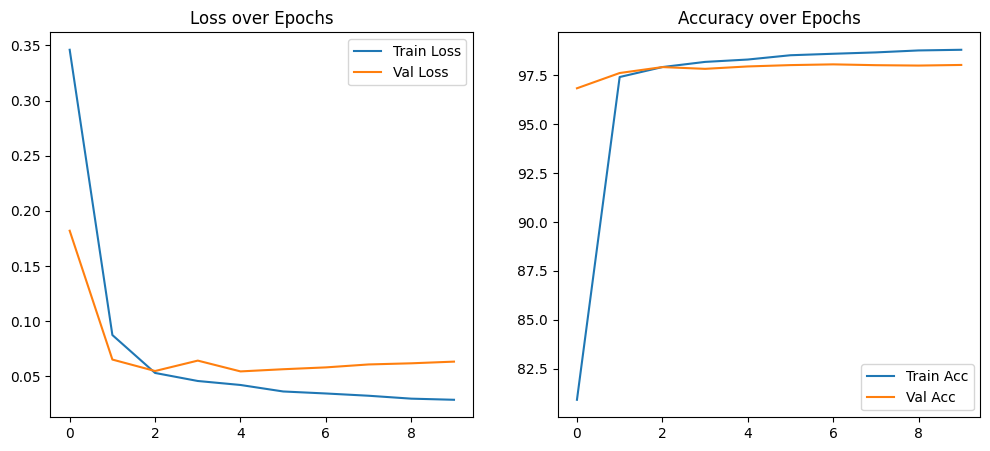

In [43]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()

In [44]:
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for x_val, y_val in val_loader:
        x_val, y_val = x_val.to(device), y_val.to(device)
        preds_val = model(x_val)
        preds_classes = torch.argmax(preds_val, dim=1).cpu().numpy()
        y_true.extend(y_val.cpu().numpy().flatten())
        y_pred.extend(preds_classes.flatten())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Background", "Lung"]))


Classification Report:
              precision    recall  f1-score   support

  Background       0.99      0.99      0.99   6903734
        Lung       0.97      0.96      0.96   2336842

    accuracy                           0.98   9240576
   macro avg       0.98      0.97      0.97   9240576
weighted avg       0.98      0.98      0.98   9240576



**DenseNet**

In [62]:
class DenseNetEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.densenet121(pretrained=True)
        self.stage0 = base.features[0]  
        self.stage1 = base.features[1]   
        self.stage2 = base.features[2]   
        self.stage3 = base.features[3]  
        self.stage4 = base.features[4]  
        self.stage5 = nn.Sequential(*base.features[5:])  

    def forward(self, x):
        skips = []
        x = self.stage0(x) 
        x = self.stage1(x)
        x = self.stage2(x)
        skips.append(x) 
        x = self.stage3(x) 
        x = self.stage4(x) 
        skips.append(x) 
        x = self.stage5(x) 
        return x, skips

class SpatialEnhancement(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.conv = nn.Conv2d(ch, ch, 3, padding=1)
        self.attn = nn.Sequential(
            nn.Conv2d(ch, ch // 8, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch // 8, ch, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv(x)
        return x * self.attn(x)

class TransformerBottleneck(nn.Module):
    def __init__(self, dim, heads=4):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=heads, batch_first=True)
        self.ffn = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.ReLU(inplace=True),
            nn.Linear(dim * 4, dim)
        )
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)

    def forward(self, x):
        B, C, H, W = x.shape
        x_flat = rearrange(x, 'b c h w -> b (h w) c')
        attn_out, _ = self.attn(x_flat, x_flat, x_flat)
        x_flat = self.norm1(x_flat + attn_out)
        x_flat = self.norm2(x_flat + self.ffn(x_flat))
        x_out = rearrange(x_flat, 'b (h w) c -> b c h w', h=H, w=W)
        return x_out

class MultiScaleFusion(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.branch1 = nn.Conv2d(ch, ch, 1)
        self.branch3 = nn.Conv2d(ch, ch, 3, padding=1)
        self.branch5 = nn.Conv2d(ch, ch, 5, padding=2)
        self.fuse = nn.Conv2d(ch * 3, ch, 1)

    def forward(self, x):
        b1 = self.branch1(x)
        b3 = self.branch3(x)
        b5 = self.branch5(x)
        out = torch.cat([b1, b3, b5], dim=1)
        return self.fuse(out)

class DecoderBlock(nn.Module):
    def __init__(self, in_ch, skip_ch):
        super().__init__()
        self.align = nn.Conv2d(in_ch, skip_ch, 1)
        self.fusion = MultiScaleFusion(skip_ch)

    def forward(self, x, skip):
        x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=True)
        x = self.align(x)
        return self.fusion(x + skip)

class SegmentationNet(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.encoder = DenseNetEncoder()
        self.spatial_enhance = nn.ModuleList([
            SpatialEnhancement(64),
            SpatialEnhancement(256)
        ])

        self.bottleneck = TransformerBottleneck(dim=1024, heads=4)

        self.decoder1 = DecoderBlock(1024, 256)
        self.decoder2 = DecoderBlock(256, 64)

        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        x, skips = self.encoder(x) 
        skips = [se(skip) for se, skip in zip(self.spatial_enhance, skips)]
        x = self.bottleneck(x)

        x = self.decoder1(x, skips[1])
        x = self.decoder2(x, skips[0])

        x = self.final_conv(x)
        x = F.interpolate(x, size=(256,256), mode='bilinear', align_corners=True)
        return x

In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [64]:
def preprocess_images(X):
    X_t = torch.tensor(X, dtype=torch.float32).permute(0,3,1,2)
    X_t = X_t.repeat(1,3,1,1)
    return X_t

In [65]:
X_train_t = preprocess_images(X_train)
y_train_t = torch.tensor(y_train, dtype=torch.long).squeeze(3) 

X_test_t = preprocess_images(X_test)
y_test_t = torch.tensor(y_test, dtype=torch.long).squeeze(3)

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False)

imagenet_mean = torch.tensor([0.485,0.456,0.406], device=device).view(1,3,1,1)
imagenet_std = torch.tensor([0.229,0.224,0.225], device=device).view(1,3,1,1)

In [66]:
model = SegmentationNet(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [67]:
num_epochs = 10
start_time = time.time()

for epoch in range(num_epochs):
    epoch_start = time.time()
    model.train()
    train_loss = 0
    correct_pixels = 0
    total_pixels = 0
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        outputs = model(imgs)
        outputs = F.interpolate(outputs, size=masks.shape[1:], mode='bilinear', align_corners=True)
        loss = criterion(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct_pixels += (preds == masks).sum().item()
        total_pixels += masks.numel()
    train_loss /= len(train_loader)
    train_acc = correct_pixels / total_pixels

    model.eval()
    val_loss = 0
    correct_pixels = 0
    total_pixels = 0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            outputs = F.interpolate(outputs, size=masks.shape[1:], mode='bilinear', align_corners=True)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct_pixels += (preds == masks).sum().item()
            total_pixels += masks.numel()
    val_loss /= len(val_loader)
    val_acc = correct_pixels / total_pixels

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    epoch_end = time.time()
    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f} Time: {(epoch_end - epoch_start):.2f} sec")

total_time = time.time() - start_time
print(f"Total training time: {total_time:.2f} seconds")


Epoch [1/10] Train Loss: 0.1868 Train Acc: 0.9183 Val Loss: 0.1196 Val Acc: 0.9557 Time: 31.01 sec
Epoch [2/10] Train Loss: 0.0769 Train Acc: 0.9695 Val Loss: 0.0745 Val Acc: 0.9715 Time: 26.21 sec
Epoch [3/10] Train Loss: 0.0601 Train Acc: 0.9759 Val Loss: 0.0681 Val Acc: 0.9741 Time: 27.21 sec
Epoch [4/10] Train Loss: 0.0536 Train Acc: 0.9783 Val Loss: 0.0666 Val Acc: 0.9754 Time: 26.63 sec
Epoch [5/10] Train Loss: 0.0476 Train Acc: 0.9808 Val Loss: 0.0644 Val Acc: 0.9768 Time: 27.35 sec
Epoch [6/10] Train Loss: 0.0421 Train Acc: 0.9827 Val Loss: 0.0633 Val Acc: 0.9773 Time: 27.51 sec
Epoch [7/10] Train Loss: 0.0406 Train Acc: 0.9836 Val Loss: 0.0673 Val Acc: 0.9745 Time: 26.31 sec
Epoch [8/10] Train Loss: 0.0404 Train Acc: 0.9836 Val Loss: 0.0632 Val Acc: 0.9778 Time: 26.30 sec
Epoch [9/10] Train Loss: 0.0362 Train Acc: 0.9852 Val Loss: 0.0675 Val Acc: 0.9775 Time: 26.42 sec
Epoch [10/10] Train Loss: 0.0339 Train Acc: 0.9860 Val Loss: 0.0617 Val Acc: 0.9790 Time: 26.32 sec
Total tra

In [68]:
torch.save(model.state_dict(), "/content/drive/MyDrive/densenet_model.pth")

In [70]:
total_time = time.time() - start_time
print(f"Total training time: {total_time:.2f} seconds")

print(f"\nFinal Training Loss: {train_losses[-1]:.4f}, Training Accuracy: {train_accs[-1]*100:.2f}%")
print(f"Final Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accs[-1]*100:.2f}%")


Total training time: 276.79 seconds

Final Training Loss: 0.0339, Training Accuracy: 98.60%
Final Validation Loss: 0.0617, Validation Accuracy: 97.90%


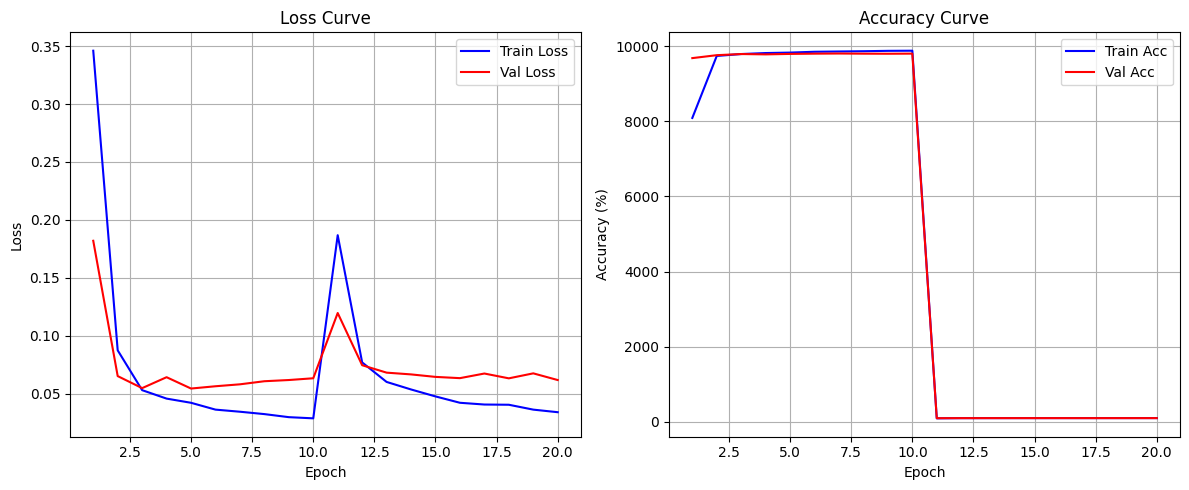

In [71]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-', label='Train Loss')
plt.plot(epochs, val_losses, 'r-', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, [acc * 100 for acc in train_accs], 'b-', label='Train Acc')
plt.plot(epochs, [acc * 100 for acc in val_accs], 'r-', label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [72]:
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for imgs, masks in val_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        outputs = model(imgs)
        outputs = F.interpolate(outputs, size=masks.shape[1:], mode='bilinear', align_corners=True)
        preds = outputs.argmax(dim=1)
        all_preds.append(preds.cpu().flatten())
        all_targets.append(masks.cpu().flatten())

all_preds_flat = torch.cat(all_preds).numpy()
all_targets_flat = torch.cat(all_targets).numpy()


In [73]:
print("\nClassification Report:")
print(classification_report(all_targets_flat, all_preds_flat, target_names=["Background", "Lung"], digits=4))


Classification Report:
              precision    recall  f1-score   support

  Background     0.9841    0.9878    0.9860   6903734
        Lung     0.9636    0.9529    0.9582   2336842

    accuracy                         0.9790   9240576
   macro avg     0.9739    0.9704    0.9721   9240576
weighted avg     0.9789    0.9790    0.9790   9240576



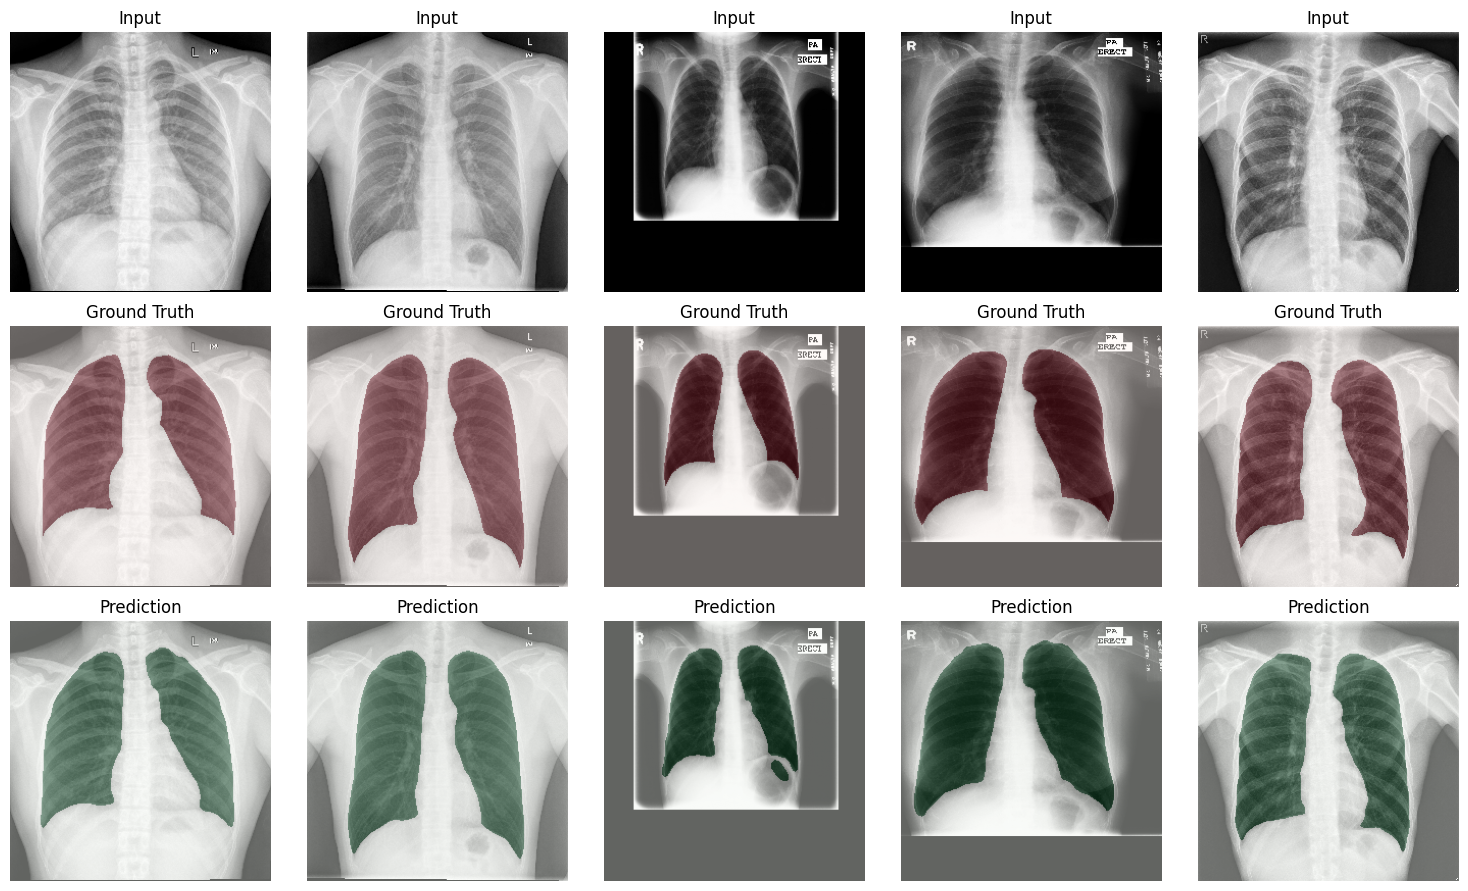

In [74]:
model.eval()
x_sample, y_sample = next(iter(val_loader))
x_sample, y_sample = x_sample.to(device), y_sample.to(device)
with torch.no_grad():
    preds_sample = model(x_sample)
preds_labels = torch.argmax(preds_sample, dim=1).cpu().numpy()

fig, axs = plt.subplots(3, 5, figsize=(15, 9))
for i in range(5):
    input_img = x_sample[i].cpu().permute(1, 2, 0).numpy()[:, :, 0]
    gt_mask = y_sample[i].cpu().numpy()
    pred_mask = preds_labels[i]

    axs[0, i].imshow(input_img, cmap='gray')
    axs[0, i].set_title("Input")
    axs[0, i].axis('off')

    axs[1, i].imshow(input_img, cmap='gray')
    axs[1, i].imshow(gt_mask, alpha=0.4, cmap='Reds')
    axs[1, i].set_title("Ground Truth")
    axs[1, i].axis('off')

    axs[2, i].imshow(input_img, cmap='gray')
    axs[2, i].imshow(pred_mask, alpha=0.4, cmap='Greens')
    axs[2, i].set_title("Prediction")
    axs[2, i].axis('off')

plt.tight_layout()
plt.show()

**VGG**

In [98]:
class VGGEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg16(pretrained=True).features
        self.stage0 = nn.Sequential(*vgg[:4])   
        self.stage1 = nn.Sequential(*vgg[4:9])  
        self.stage2 = nn.Sequential(*vgg[9:16]) 
        self.stage3 = nn.Sequential(*vgg[16:23]
        self.stage4 = nn.Sequential(*vgg[23:30])

    def forward(self, x):
        skips = []
        x = self.stage0(x)
        skips.append(x)
        x = self.stage1(x)
        skips.append(x)
        x = self.stage2(x)
        skips.append(x)
        x = self.stage3(x)
        skips.append(x)
        x = self.stage4(x)
        return x, skips

class SpatialEnhancement(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.conv = nn.Conv2d(ch, ch, 3, padding=1)
        self.attn = nn.Sequential(
            nn.Conv2d(ch, ch // 8, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch // 8, ch, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv(x)
        return x * self.attn(x)

class TransformerBottleneck(nn.Module):
    def __init__(self, dim, heads=4):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=heads, batch_first=True)
        self.ffn = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.ReLU(inplace=True),
            nn.Linear(dim * 4, dim)
        )
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)

    def forward(self, x):
        B, C, H, W = x.shape
        x_flat = rearrange(x, 'b c h w -> b (h w) c')
        attn_out, _ = self.attn(x_flat, x_flat, x_flat)
        x_flat = self.norm1(x_flat + attn_out)
        x_flat = self.norm2(x_flat + self.ffn(x_flat))
        x_out = rearrange(x_flat, 'b (h w) c -> b c h w', h=H, w=W)
        return x_out

class MultiScaleFusion(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.branch1 = nn.Conv2d(ch, ch, 1)
        self.branch3 = nn.Conv2d(ch, ch, 3, padding=1)
        self.branch5 = nn.Conv2d(ch, ch, 5, padding=2)
        self.fuse = nn.Conv2d(ch * 3, ch, 1)

    def forward(self, x):
        b1 = self.branch1(x)
        b3 = self.branch3(x)
        b5 = self.branch5(x)
        out = torch.cat([b1, b3, b5], dim=1)
        return self.fuse(out)

class DecoderBlock(nn.Module):
    def __init__(self, in_ch, skip_ch):
        super().__init__()
        self.align = nn.Conv2d(in_ch, skip_ch, 1)
        self.fusion = MultiScaleFusion(skip_ch)

    def forward(self, x, skip):
        x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=True)
        x = self.align(x)
        return self.fusion(x + skip)

class SegmentationNet(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.encoder = VGGEncoder()
        self.spatial_enhance = nn.ModuleList([
            SpatialEnhancement(64),    
            SpatialEnhancement(128),  
            SpatialEnhancement(256),  
            SpatialEnhancement(512)   
        ])

        self.bottleneck = TransformerBottleneck(dim=512, heads=4)

        self.decoder1 = DecoderBlock(512, 512)
        self.decoder2 = DecoderBlock(512, 256)
        self.decoder3 = DecoderBlock(256, 128)
        self.decoder4 = DecoderBlock(128, 64)

        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        x, skips = self.encoder(x)
        skips = [se(skip) for se, skip in zip(self.spatial_enhance, skips)]
        x = self.bottleneck(x)
        x = self.decoder1(x, skips[3])
        x = self.decoder2(x, skips[2])
        x = self.decoder3(x, skips[1])
        x = self.decoder4(x, skips[0])
        x = self.final_conv(x)
        x = F.interpolate(x, size=(256,256), mode='bilinear', align_corners=True)
        return x


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def preprocess_images(X):
    X_t = torch.tensor(X, dtype=torch.float32).permute(0,3,1,2)
    X_t = X_t.repeat(1,3,1,1)  
    return X_t

X_train_t = preprocess_images(X_train)
y_train_t = torch.tensor(y_train, dtype=torch.long).squeeze(3)

X_test_t = preprocess_images(X_test)
y_test_t = torch.tensor(y_test, dtype=torch.long).squeeze(3)

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False)

imagenet_mean = torch.tensor([0.485,0.456,0.406], device=device).view(1,3,1,1)
imagenet_std = torch.tensor([0.229,0.224,0.225], device=device).view(1,3,1,1)

In [99]:
model = SegmentationNet(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 10
start_time = time.time()

train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):
    epoch_start = time.time()
    model.train()
    train_loss = 0
    correct_pixels = 0
    total_pixels = 0
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        imgs = (imgs - imagenet_mean) / imagenet_std 
        outputs = model(imgs)
        outputs = F.interpolate(outputs, size=masks.shape[1:], mode='bilinear', align_corners=True)
        loss = criterion(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct_pixels += (preds == masks).sum().item()
        total_pixels += masks.numel()
    train_loss /= len(train_loader)
    train_acc = correct_pixels / total_pixels

    model.eval()
    val_loss = 0
    correct_pixels = 0
    total_pixels = 0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            imgs = (imgs - imagenet_mean) / imagenet_std 
            outputs = model(imgs)
            outputs = F.interpolate(outputs, size=masks.shape[1:], mode='bilinear', align_corners=True)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct_pixels += (preds == masks).sum().item()
            total_pixels += masks.numel()
    val_loss /= len(val_loader)
    val_acc = correct_pixels / total_pixels

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} — train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} val_loss: {val_loss:.4f} val_acc: {val_acc:.4f} — time: {time.time()-epoch_start:.1f}s")

print(f"Total training time: {time.time()-start_time:.1f}s")


Epoch 1/10 — train_loss: 0.1262 train_acc: 0.9491 val_loss: 0.0561 val_acc: 0.9789 — time: 71.4s
Epoch 2/10 — train_loss: 0.0530 train_acc: 0.9799 val_loss: 0.0531 val_acc: 0.9803 — time: 69.1s
Epoch 3/10 — train_loss: 0.0474 train_acc: 0.9815 val_loss: 0.0565 val_acc: 0.9798 — time: 68.9s
Epoch 4/10 — train_loss: 0.0436 train_acc: 0.9825 val_loss: 0.0548 val_acc: 0.9805 — time: 69.1s
Epoch 5/10 — train_loss: 0.0382 train_acc: 0.9844 val_loss: 0.0506 val_acc: 0.9805 — time: 69.0s
Epoch 6/10 — train_loss: 0.0346 train_acc: 0.9859 val_loss: 0.0545 val_acc: 0.9808 — time: 68.9s
Epoch 7/10 — train_loss: 0.0317 train_acc: 0.9870 val_loss: 0.0593 val_acc: 0.9810 — time: 68.8s
Epoch 8/10 — train_loss: 0.0294 train_acc: 0.9878 val_loss: 0.0627 val_acc: 0.9798 — time: 69.0s
Epoch 9/10 — train_loss: 0.0277 train_acc: 0.9884 val_loss: 0.0633 val_acc: 0.9804 — time: 69.0s
Epoch 10/10 — train_loss: 0.0257 train_acc: 0.9892 val_loss: 0.0634 val_acc: 0.9804 — time: 69.0s
Total training time: 692.1s


In [100]:
torch.save(model.state_dict(), "/content/drive/MyDrive/VGG_model.pth")

In [101]:
total_time = time.time() - start_time
print(f"Total training time: {total_time:.2f} seconds")
print(f"\nFinal Training Loss: {train_losses[-1]:.4f}, Training Accuracy: {train_accs[-1]*100:.2f}%")
print(f"Final Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accs[-1]*100:.2f}%")

Total training time: 848.09 seconds

Final Training Loss: 0.0257, Training Accuracy: 98.92%
Final Validation Loss: 0.0634, Validation Accuracy: 98.04%


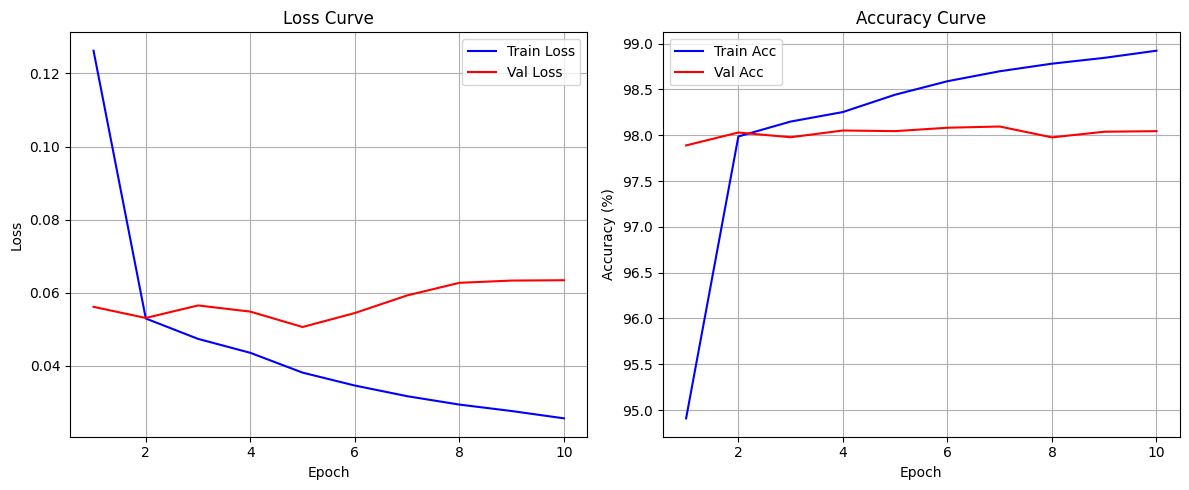

In [102]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-', label='Train Loss')
plt.plot(epochs, val_losses, 'r-', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, [acc * 100 for acc in train_accs], 'b-', label='Train Acc')
plt.plot(epochs, [acc * 100 for acc in val_accs], 'r-', label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [103]:
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for imgs, masks in val_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        imgs = (imgs - imagenet_mean) / imagenet_std
        outputs = model(imgs)
        outputs = F.interpolate(outputs, size=masks.shape[1:], mode='bilinear', align_corners=True)
        preds = outputs.argmax(dim=1)
        all_preds.append(preds.cpu().flatten())
        all_targets.append(masks.cpu().flatten())

all_preds_flat = torch.cat(all_preds).numpy()
all_targets_flat = torch.cat(all_targets).numpy()

print("\nClassification Report:")
print(classification_report(all_targets_flat, all_preds_flat, target_names=["Background", "Lung"], digits=4))


Classification Report:
              precision    recall  f1-score   support

  Background     0.9840    0.9899    0.9870   6903734
        Lung     0.9697    0.9524    0.9610   2336842

    accuracy                         0.9804   9240576
   macro avg     0.9769    0.9712    0.9740   9240576
weighted avg     0.9804    0.9804    0.9804   9240576



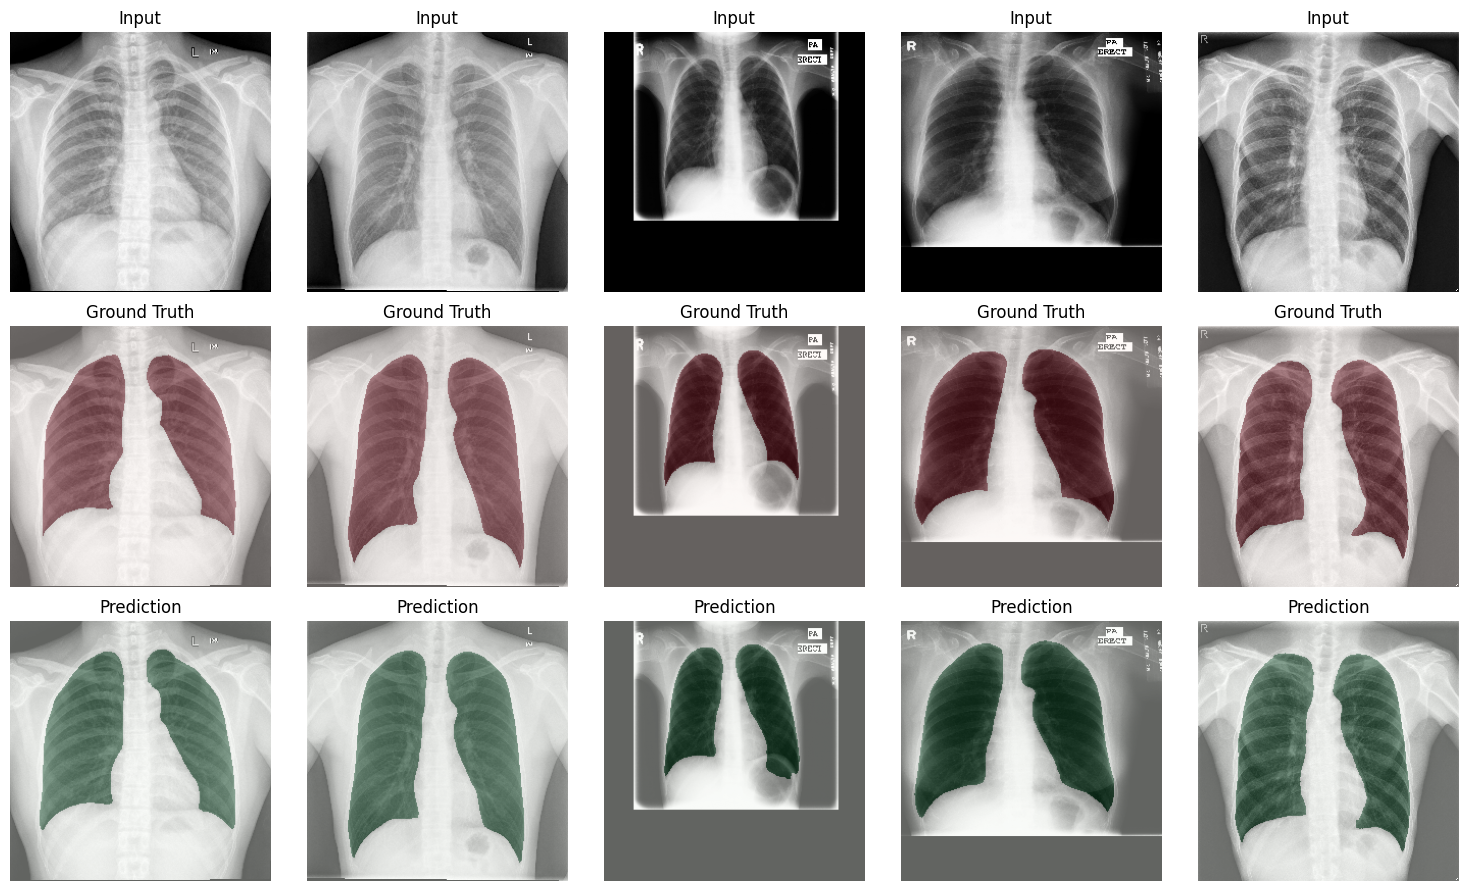

In [104]:
x_sample, y_sample = next(iter(val_loader))
x_sample, y_sample = x_sample.to(device), y_sample.to(device)
with torch.no_grad():
    preds_sample = model((x_sample - imagenet_mean) / imagenet_std)
preds_labels = torch.argmax(preds_sample, dim=1).cpu().numpy()

fig, axs = plt.subplots(3, 5, figsize=(15, 9))
for i in range(5):
    input_img = x_sample[i].cpu().permute(1, 2, 0).numpy()[:, :, 0]
    gt_mask = y_sample[i].cpu().numpy()
    pred_mask = preds_labels[i]

    axs[0, i].imshow(input_img, cmap='gray')
    axs[0, i].set_title("Input")
    axs[0, i].axis('off')

    axs[1, i].imshow(input_img, cmap='gray')
    axs[1, i].imshow(gt_mask, alpha=0.4, cmap='Reds')
    axs[1, i].set_title("Ground Truth")
    axs[1, i].axis('off')

    axs[2, i].imshow(input_img, cmap='gray')
    axs[2, i].imshow(pred_mask, alpha=0.4, cmap='Greens')
    axs[2, i].set_title("Prediction")
    axs[2, i].axis('off')

plt.tight_layout()
plt.show()